In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

ipykernel_launcher:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## Data Cleaning(short cut:Rating(점수) 3점 이상의 데이터만 수집)
1~2점은 다음에 안볼 것이다 가정

In [4]:
data = data[data['Rating']>=3]

In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [6]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_999

1      0.000166
7      0.000331
9      0.000994
10     0.001159
11     0.001987
         ...   
725    0.989237
726    0.989402
728    0.989568
731    0.989733
734    0.989899
Length: 584, dtype: float64

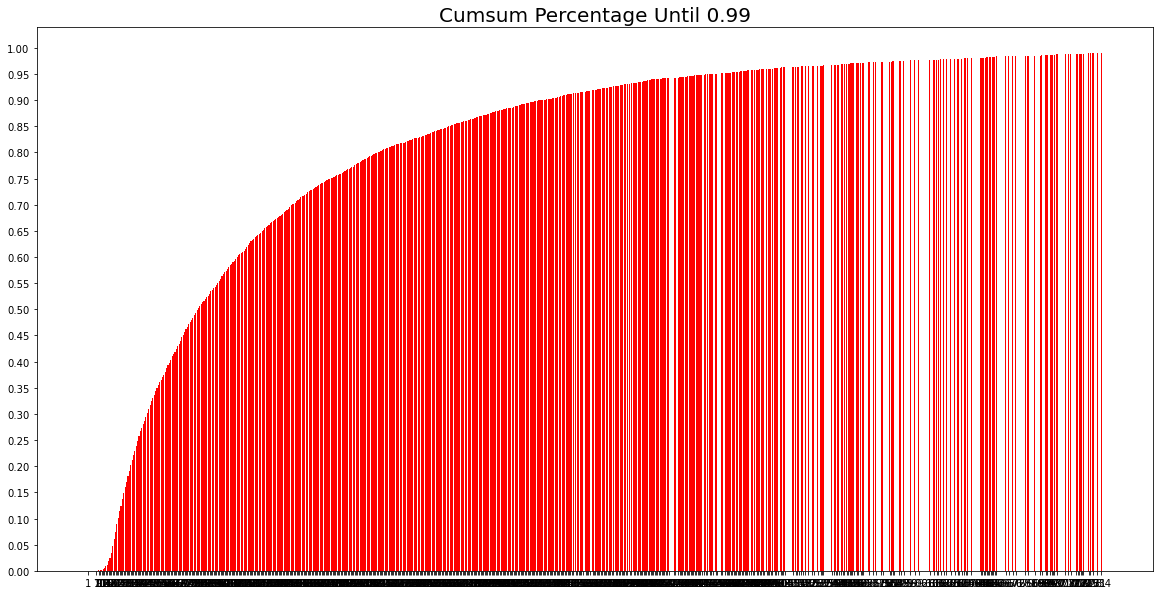

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

In [8]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


## Data Cleaning(unpopular cut:최신 영화 평가만 수집)
현재 상영할만한 최신영화만 수집

In [9]:
month_ago = latest - 12*30*3600*24     # 최종 날짜로부터 12달 이전 날짜를 구한다.  
datas = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
datas
# month_ago

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


In [10]:
def split_by_date(data: pd.DataFrame, monts: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - monts*30*3600*24].index
    session_in_test = session_last_time[session_last_time >= final_time - monts*30*3600*24].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [11]:
tr,test = split_by_date(datas,monts=1)
tr,val = split_by_date(tr,monts=1)

In [12]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [13]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 8597
	 Sessions: 305
	 Items: 2165
	 First Time : 1015352875
	 Last Time : 1041215174

* valid Set Stats Info
	 Events: 2476
	 Sessions: 81
	 Items: 1176
	 First Time : 1015374516
	 Last Time : 1043809240

* test Set Stats Info
	 Events: 5363
	 Sessions: 98
	 Items: 1772
	 First Time : 1015447061
	 Last Time : 1046454590



In [14]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [15]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [16]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [17]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
5359,36,2115,5,1015904905,5
5073,36,1912,5,1015904924,6
5113,36,2662,3,1015904924,7
5366,36,2985,4,1015904941,8
5305,36,2527,3,1015904957,9


In [18]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [19]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
5359,36,2115,5,1015904905,5
5073,36,1912,5,1015904924,6
5113,36,2662,3,1015904924,7
5366,36,2985,4,1015904941,8
5305,36,2527,3,1015904957,9


In [20]:
iter_ex = iter(tr_data_loader)
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 33 39 49]
Label Item Idx are :       [ 1 34 40 50]
Previous Masked Input Idx are []


In [21]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [22]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [23]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=30, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
args2 = Args(tr, val, test, batch_size=30, hsz=50, drop_rate=0.2, lr=0.001, epochs=3, k=20)
args3 = Args(tr, val, test, batch_size=30, hsz=50, drop_rate=0.3, lr=0.001, epochs=3, k=20)

In [24]:
model = create_model(args)
model1 = create_model(args2)
model2 = create_model(args3)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(30, 1, 2165)]           0         
_________________________________________________________________
GRU (GRU)                    [(30, 50), (30, 50)]      332550    
_________________________________________________________________
dropout (Dropout)            (30, 50)                  0         
_________________________________________________________________
dense (Dense)                (30, 2165)                110415    
Total params: 442,965
Trainable params: 442,965
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(30, 1, 2165)]           0         
______________________________________

In [25]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [26]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/276 [00:00<?, ?it/s, accuracy=0, train_loss=6.75]	 - Recall@20 epoch 1: 0.047407
	 - MRR@20    epoch 1: 0.010337

Train:   0%|          | 0/276 [00:00<?, ?it/s, accuracy=0, train_loss=6.71]	 - Recall@20 epoch 2: 0.049630
	 - MRR@20    epoch 2: 0.009920

Evaluation:  57%|█████▋    | 45/79 [00:06<00:04,  7.03it/s]	 - Recall@20 epoch 3: 0.045926
	 - MRR@20    epoch 3: 0.008854




In [30]:
train_model(model1, args2)
train_model(model2, args3)

Train:   0%|          | 0/276 [00:00<?, ?it/s, accuracy=0, train_loss=6.74]	 - Recall@20 epoch 1: 0.050370
	 - MRR@20    epoch 1: 0.010255

Train:   0%|          | 0/276 [00:00<?, ?it/s, accuracy=0, train_loss=6.7] 	 - Recall@20 epoch 2: 0.045926
	 - MRR@20    epoch 2: 0.010300

Train:   0%|          | 0/276 [00:00<?, ?it/s, accuracy=0, train_loss=6.65]	 - Recall@20 epoch 3: 0.045926
	 - MRR@20    epoch 3: 0.009004

Train:   0%|          | 0/276 [00:00<?, ?it/s, accuracy=0, train_loss=6.76]	 - Recall@20 epoch 1: 0.051111
	 - MRR@20    epoch 1: 0.010186

Train:   0%|          | 0/276 [00:00<?, ?it/s, accuracy=0, train_loss=6.75]	 - Recall@20 epoch 2: 0.051852
	 - MRR@20    epoch 2: 0.010032

Evaluation:  57%|█████▋    | 45/79 [00:06<00:04,  7.16it/s]	 - Recall@20 epoch 3: 0.051111
	 - MRR@20    epoch 3: 0.010527




In [27]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  63%|██████▎   | 111/175 [00:15<00:09,  7.08it/s]	 - Recall@20: 0.036036
	 - MRR@20: 0.005866




In [31]:
test_model(model1,args2,test)
test_model(model2,args3,test)


Evaluation:   0%|          | 0/175 [00:00<?, ?it/s]	 - Recall@20: 0.036637
	 - MRR@20: 0.005956

Evaluation:  63%|██████▎   | 111/175 [00:15<00:08,  7.16it/s]	 - Recall@20: 0.039640
	 - MRR@20: 0.007048




# 고찰
단순히 drop_out의 비율만 바꾸어 실험하였습니다.  
10프로와 20프로는 비슷한 결과가 나왔지만,  
30프로는 epoch가 부족해 안좋은 결과가 나온것으로 보입니다. 

# 아쉬운 점
이번 노드에서는 진짜 제대로 된 이해보다 그런게 있구나만 하고 넘어간 점이 너무 많았다.  
노드 나온날에 바로 다 끝내고 아무생각 없이 일주일 지나고 보니 기억에 남는 것이 가장 적었던 노드로 인상 깊었다.